# Wind Speed

## Import Libraries

In [1]:
pip install keras-tcn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tcn import TCN
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, concatenate

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import plotly.express as px
import os
import csv

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from keras.preprocessing.sequence import TimeseriesGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
# from keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

## Read CSV

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('/kaggle/input/btpdata/Jaisalmer.csv',index_col='Date/Time', parse_dates=True)

In [5]:
dataset = 'jaisalmer'
savefilename = 'jaisalmer.csv'

In [6]:
df.shape

(35040, 4)

In [7]:
df = df[df.index.minute == 0]

In [8]:
df = pd.DataFrame({'120m' : df['120m']}, index=df.index)

In [9]:
display(df)

,120m
Date/Time,
2014-01-01 00:00:00,9.90
2014-01-01 01:00:00,9.48
2014-01-01 02:00:00,9.98
2014-01-01 03:00:00,10.30
2014-01-01 04:00:00,10.39
...,...
2014-12-31 19:00:00,7.48
2014-12-31 20:00:00,9.21
2014-12-31 21:00:00,10.41


In [10]:
df.describe()

,120m
count,8760.000000
mean,7.322581
std,3.823339
min,0.030000
25%,4.330000
50%,6.840000
75%,9.980000
max,19.950000


In [11]:
df.isna().sum()

120m    0
dtype: int64

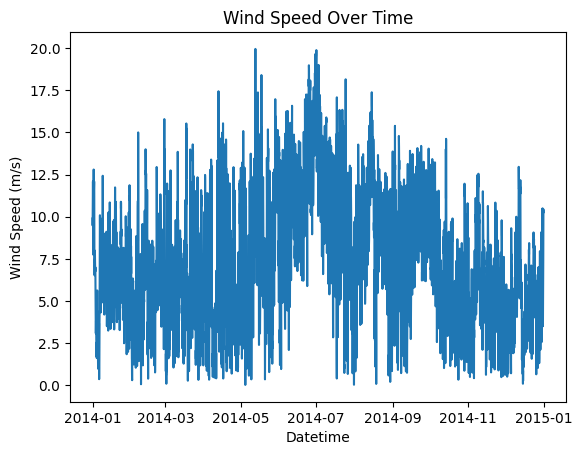

In [12]:
plt.plot(df)
plt.title('Wind Speed Over Time')
plt.xlabel('Datetime')
plt.ylabel('Wind Speed (m/s)')
plt.savefig('jaisalmer.png')
plt.show()

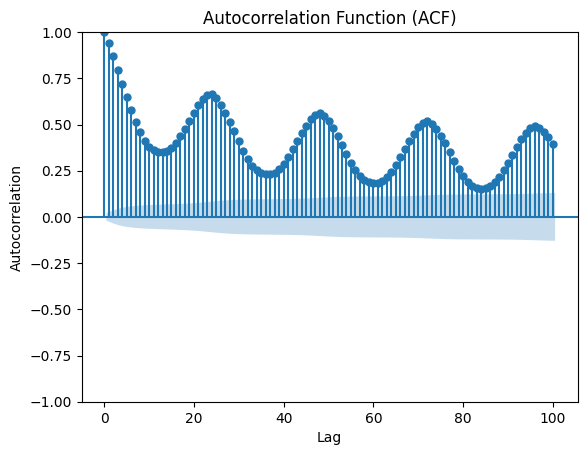

In [13]:
plot_acf(df, lags=100)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

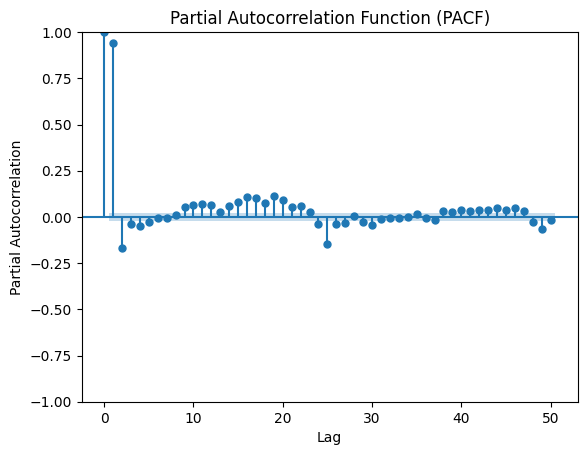

In [14]:
plot_pacf(df, lags=50)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

## Define Loss and Model

### Loss

#### QD Loss


In [15]:
from tensorflow.keras.utils import register_keras_serializable


In [16]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
# for qd_objective
# lambda_ = 0.05 # lambda in loss fn
alpha_ = 0.1  # capturing (1-alpha)% of samples
soften_ = 160. #160
n_ = 128 # batch size
lambda1 = 0.95
lambda2 = 0.05

def change_qd_var(alpha, soften, n, l1, l2):
    global alpha_, soften_, n_, lambda1, lambda2
    alpha_ = alpha
    soften_ = soften
    n_ = n
    lambda1 = l1
    lambda2 = l2

@register_keras_serializable()
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:, 0]
    y_u = y_pred[:, 0]
    y_l = y_pred[:, 1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)

    # Calculate MPIW_c using tf.cond
    sum_K_S = tf.reduce_sum(K_S)
    numerator_MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l), K_S))
    MPIW_c = tf.cond(
        pred=tf.equal(sum_K_S, 0),
        true_fn=lambda: tf.constant(0.0, dtype=tf.float32),
        false_fn=lambda: numerator_MPIW_c / (sum_K_S + 1e-8)
    )

    PICP_S = tf.reduce_mean(K_S)

    penalty = tf.maximum(0.0, y_l - y_true) + tf.maximum(0.0, y_true - y_u)
    non_zero_terms = tf.boolean_mask(penalty, penalty > 0)

    # Calculate pen_loss using tf.cond
    size = tf.size(non_zero_terms)
    pen_loss = tf.cond(
        pred=tf.equal(size, 0),
        true_fn=lambda: tf.constant(0.0, dtype=tf.float32),
        false_fn=lambda: tf.reduce_mean(non_zero_terms)
    )

    Loss_S = lambda1 * MPIW_c + \
             lambda2 * n_ / (alpha_ * (1 - alpha_)) * tf.square(tf.maximum(0.0, (1 - alpha_) - PICP_S)) + \
             pen_loss
    return Loss_S

#### Confidence Loss(Tube Loss)

In [17]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
# for confidance loss
r= 0.95 # confidence {0-1}
q = 0.95
delta = 0.002 # 0.05,0.1
qq1 = 0.025
qq2 = 0.975

def change_confidence_var(r_, q_, delta_):
    global r, q, delta
    r = r_
    q = q_
    delta = delta_

def confidence_loss(y_true, y_pred):
    y_true = y_true[:, 0]
    f1 = y_pred[:, 0]
    f2 = y_pred[:, 1]

    c1 = (1 - q) * (y_true - f2)
    c2 = (1 - q) * (f1 - y_true)
    c3 = q * (f2 - y_true)
    c4 = q * (y_true - f1)

    condition1 = tf.math.logical_and(y_true <= f1, y_true >= f2)
    condition2 = y_true > (r * f1 + (1 - r) * f2)
    condition3 = f2 > y_true

    loss_part1 = tf.where(condition1,
                          tf.where(condition2, c1, c2),
                          tf.where(condition3, c3, c4))
    loss = loss_part1 + (delta * tf.math.abs(f1 - f2))
    return loss

#### Quantile Loss

In [18]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * e, (quantile - 1) * e), axis=-1)
    return loss

### LSTM Model

In [19]:
def create_lstm(input_shape, layer_units, output_units, dropout_rate=0.0):
    model = Sequential()
    for i, units in enumerate(layer_units[:-1]):
        model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape, activation="relu"))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))  # Adding dropout between LSTM layers
    # Last LSTM layer without return_sequences
    model.add(LSTM(units=layer_units[-1], activation="relu"))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))  # Adding dropout after the last LSTM layer
    model.add(Dense(output_units))  # Output layer
    return model

### GRU Model


In [20]:
def create_gru(input_shape, layer_units, output_units, dropout_rate=0.0):
    model = Sequential()
    for i, units in enumerate(layer_units[:-1]):
        model.add(GRU(units=units, return_sequences=True, input_shape=input_shape, activation="relu"))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))  # Adding dropout between GRU layers
    # Last GRU layer without return_sequences
    model.add(GRU(units=layer_units[-1], activation="relu"))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))  # Adding dropout after the last GRU layer
    model.add(Dense(output_units))  # Output layer
    return model

### TCN Model

In [21]:
# def create_tcn(input_shape, layer_units, output_units, kernel=3, dropout_rate=0.0):
#     model = Sequential()
#     # print(layer_units)
#     i=0
#     for units in layer_units[:-1]:
#         model.add(TCN(nb_filters=units, kernel_size=kernel, nb_stacks=1, dilations=[2**i], dropout_rate=dropout_rate, return_sequences=True,activation='relu'))
#         i=i+1
#     model.add(TCN(nb_filters=layer_units[-1], kernel_size=kernel, nb_stacks=1, dilations=[2**i], dropout_rate=dropout_rate,activation='relu'))
#     model.add(Dense(output_units))  # Output layer
#     return model

In [22]:
from tensorflow.keras.layers import Input, Conv1D, ReLU, Dropout, Add, Flatten, Dense
from tensorflow.keras.models import Model

def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    original_x = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    if original_x.shape[-1] != filters:
        original_x = Conv1D(filters=filters, kernel_size=1, padding='same')(original_x)
    x = Add()([original_x, x])
    return x


In [23]:
def create_tcn(input_shape, filters_list, kernel_size, dropout_rate):
    input_layer = Input(shape=input_shape)
    x = input_layer
    dilation_rates = [2**i for i in range(len(filters_list))]
    for filters, dilation_rate in zip(filters_list, dilation_rates):
        x = tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate)
    x = Flatten()(x)
    output_layer = Dense(2)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Train and Test

#### Split Data

In [24]:
input_window_size = 24  # window size

In [25]:
# Time-based train-test split
validation_size = 0.15
test_size = 0.15
split_index_val = int(len(df) * (1 - validation_size - test_size))
split_index_test = int(len(df) * (1 - test_size))

train_data = df[:split_index_val]
validation_data = df[split_index_val:split_index_test]
test_data = df[split_index_test:]

In [26]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [27]:
train_x, train_y = truncate(train_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)
val_x, val_y = truncate(validation_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)
test_x, test_y = truncate(test_data.values, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=input_window_size, test_len=1)

In [28]:
print("Train shapes:", train_x.shape, train_y.shape)
print("Validation shapes:", val_x.shape, val_y.shape)
print("Test shapes:", test_x.shape, test_y.shape)

Train shapes: (6108, 24, 1) (6108, 1, 1)
Validation shapes: (1290, 24, 1) (1290, 1, 1)
Test shapes: (1290, 24, 1) (1290, 1, 1)


#### MinMax Normalization

In [29]:
# Min-Max normalization for input features
scaler_x = MinMaxScaler()
scaler_x.fit(train_x.reshape(-1, 1))  # Fit scaler only on training data
train_x = scaler_x.transform(train_x.reshape(-1, 1)).reshape(train_x.shape)
val_x = scaler_x.transform(val_x.reshape(-1, 1)).reshape(val_x.shape)
test_x = scaler_x.transform(test_x.reshape(-1, 1)).reshape(test_x.shape)

# Min-Max normalization for target values
scaler_y = MinMaxScaler()
scaler_y.fit(train_y.reshape(-1, 1))  # Fit scaler only on training data
train_y = scaler_y.transform(train_y.reshape(-1, 1)).reshape(train_y.shape)
val_y = scaler_y.transform(val_y.reshape(-1, 1)).reshape(val_y.shape)
test_y = scaler_y.transform(test_y.reshape(-1, 1)).reshape(test_y.shape)

#### Model Train

##### Save to CSV

In [30]:
def save_to_csv(filename, *data):
    try:
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(data)
        print("Data appended successfully to", filename)
    except Exception as e:
        print("Error:", e)

# save_to_csv(savefilename, "")

In [31]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

##### QD

###### QD LSTM

In [32]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for layers in [[128]]:
        for alp in [0.05]:
            for sof in [300]:
                for l1 in [2]:
                    for l2 in [0.003]:
                        change_qd_var(alp, sof, 128, l1, l2)
                        QD = create_lstm((input_window_size,1),layers,2,dropout)
                        QD.compile(loss=qd_objective,optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = QD.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(),2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = QD.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv("qd_"+savefilename, dataset, "QD_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)
                        print(dataset, "QD_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)


Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 6.2471 - val_loss: 1.0125
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1245 - val_loss: 0.9493
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0380 - val_loss: 0.8830
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9912 - val_loss: 0.8289
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9468 - val_loss: 0.8394
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9198 - val_loss: 0.8308
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8652 - val_loss: 0.7246
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8632 - val_loss: 0.7754
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8545 - val_loss: 0.7429
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8748 - val_loss: 1.2288
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0197 - val_loss: 0.7001
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

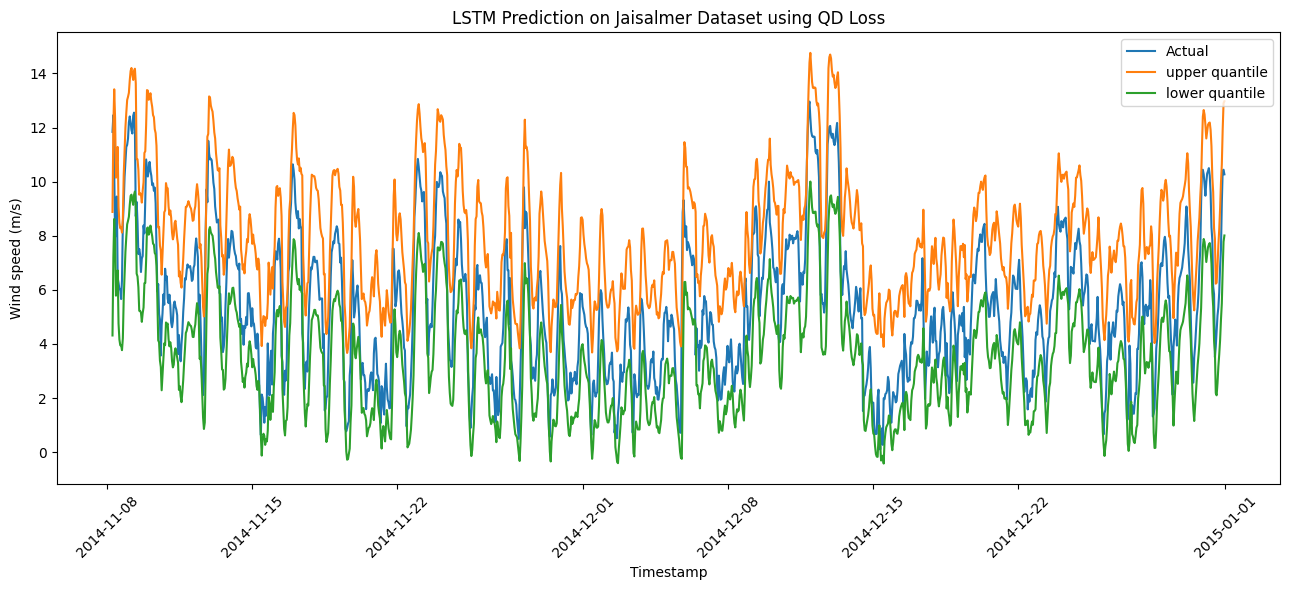

In [36]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM Prediction on Jaisalmer Dataset using QD Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [37]:
QD.save('j_lstm_qd.keras')

###### QD GRU

In [38]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for layers in [[128]]:
        for alp in [0.05]:
            for sof in [300]:
                for l1 in [2]:
                    for l2 in [0.003]:
                        gru_model = create_gru((input_window_size, 1), layers, 2, dropout)
                        change_qd_var(alp, sof, 128, l1, l2)
                        gru_model.compile(loss=qd_objective, optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = gru_model.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(), 2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = gru_model.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv("qd_"+savefilename, dataset, "QD_GRU", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout)

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 6.5203 - val_loss: 1.2899
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1112 - val_loss: 0.8794
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9515 - val_loss: 0.8047
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8488 - val_loss: 0.8390
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8114 - val_loss: 0.6129
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7030 - val_loss: 0.5860
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6955 - val_loss: 0.6404
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7291 - val_loss: 0.5812
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6551 - val_loss: 0.5824
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7038 - val_loss: 0.6198
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6392 - val_loss: 0.5439
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

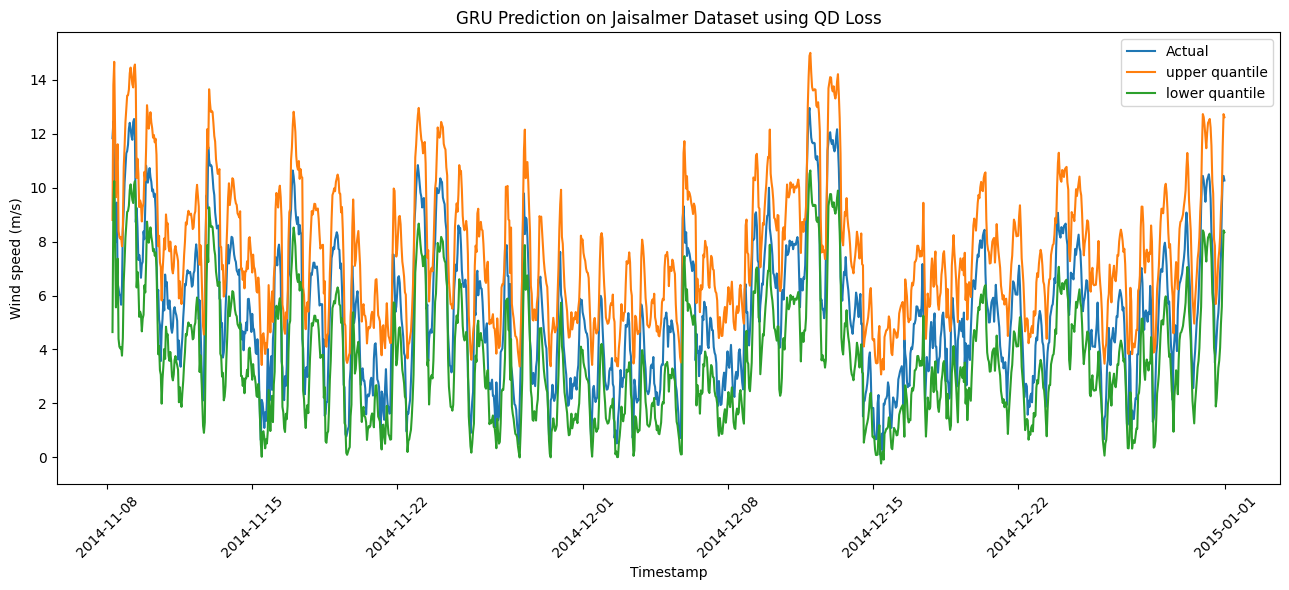

In [39]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU Prediction on Jaisalmer Dataset using QD Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [40]:
gru_model.save('j_gru_qd.keras')

###### QD TCN

In [41]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for kernel in [3]:
        for layers in [[128]]:
            for alp in [0.05]:
                for sof in [300]:
                    for l1 in [5]:
                        for l2 in [0.005]:
                            change_qd_var(alp, sof, 128, l1, l2)
                            tcn_model = create_tcn((input_window_size,1), layers, kernel, dropout)
                            tcn_model.compile(loss=qd_objective, optimizer=Adam(learning_rate=0.001))
                            epc = 300
                            stop_patience = 10
                            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                            start_time = datetime.datetime.now()
                            history = tcn_model.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                            end_time = datetime.datetime.now()
                            total_time = end_time - start_time
                            total_time = round(total_time.total_seconds(), 2)
                            print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                            y_pred = tcn_model.predict(test_x, verbose=0)
                            y_pred = scaler_y.inverse_transform(y_pred)
                            test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                            test_y_ = np.squeeze(test_y_[:,0])
                            y_u_pred = y_pred[:,0]
                            y_l_pred = y_pred[:,1]
                            K_u = y_u_pred > test_y_
                            K_l = y_l_pred < test_y_
                            PICP = np.mean(K_u * K_l)
                            MPIW = np.round(np.mean(y_u_pred - y_l_pred), 3)
                            print('PICP:', PICP)
                            print('MPIW:', MPIW)
                            save_to_csv("qd_"+savefilename, dataset, "TCN", PICP, MPIW, total_time, stop_patience, input_window_size, alpha_, soften_, n_, lambda1, lambda2, layers, dropout, kernel, "improve")

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 5.5366 - val_loss: 1.7108
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7478 - val_loss: 1.2179
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5471 - val_loss: 1.3229
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4274 - val_loss: 1.2059
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2824 - val_loss: 1.0883
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2484 - val_loss: 1.1709
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2273 - val_loss: 0.9962
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1610 - val_loss: 0.9444
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1997 - val_loss: 1.1274
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1233 - val_loss: 1.0429
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0662 - val_loss: 0.8934
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

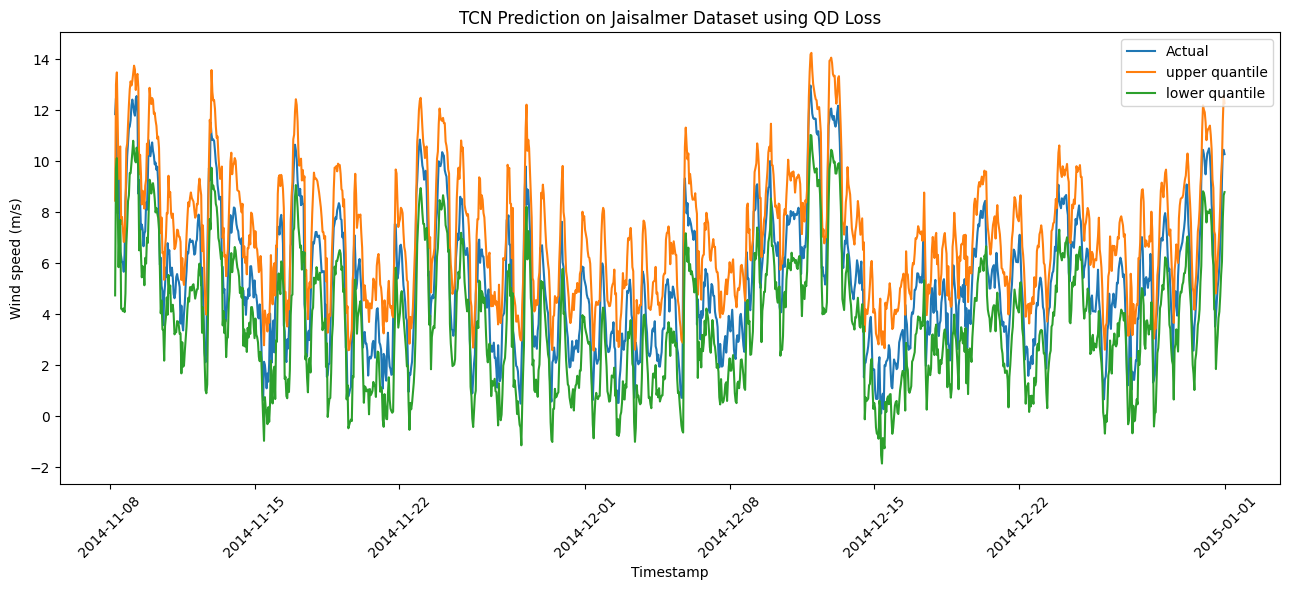

In [42]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13,6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN Prediction on Jaisalmer Dataset using QD Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [43]:
tcn_model.save('j_tcn_qd.keras')

##### Confidence Loss

###### Confidence LSTM

In [44]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for layers in [[32,32]]:
    for ri in [0.5]:
        for qi in [0.975]:
            for deltai in [0.05]:
                change_confidence_var(ri, qi, deltai)
                Confidence = create_lstm((input_window_size,1),layers,2)
                Confidence.compile(loss=confidence_loss,optimizer=Adam(learning_rate=0.001))
                epc = 300
                stop_patience = 10
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                start_time = datetime.datetime.now()
                history = Confidence.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                end_time = datetime.datetime.now()
                total_time = end_time - start_time
                total_time = round(total_time.total_seconds(),2)
                print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                y_pred = Confidence.predict(test_x, verbose=0)
                y_pred = scaler_y.inverse_transform(y_pred)
                test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                test_y_ = np.squeeze(test_y_[:,0])
                y_u_pred = y_pred[:,0]
                y_l_pred = y_pred[:,1]
                K_u = y_u_pred > test_y_
                K_l = y_l_pred < test_y_
                PICP = np.mean(K_u * K_l)
                MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                print('PICP:', PICP)
                print('MPIW:', MPIW)
                save_to_csv(savefilename, dataset, "Confidence_LSTM", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta, layers)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.2323 - val_loss: 0.0343
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0407 - val_loss: 0.0323
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385 - val_loss: 0.0310
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0364 - val_loss: 0.0285
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337 - val_loss: 0.0252
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0292 - val_loss: 0.0224
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260 - val_loss: 0.0218
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0243 - val_loss: 0.0191
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219 - val_loss: 0.0187
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - val_loss: 0.0164
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0204 - val_loss: 0.0171
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0206 - val_l

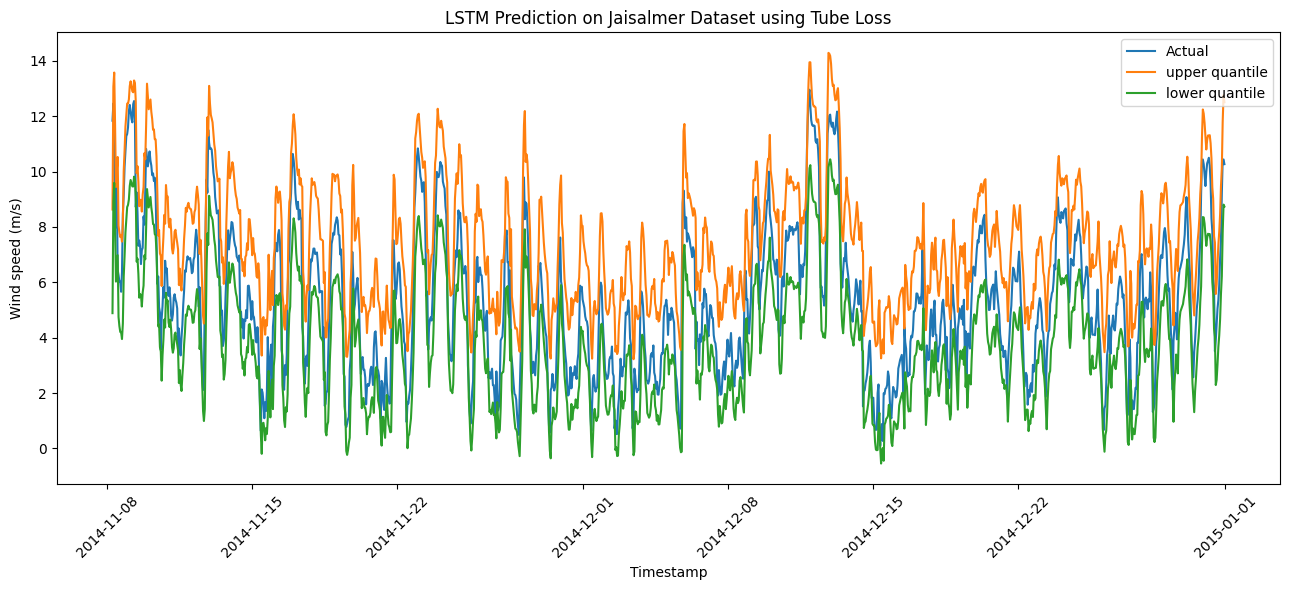

In [46]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13,6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM Prediction on Jaisalmer Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [47]:
Confidence.save('j_LSTM_Confidence.keras')

###### Confidence GRU

In [48]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for layers in [[16,16]]:
        for ri in [0.5]:
            for qi in [0.95]:
                for deltai in [0.05]:
                    change_confidence_var(ri, qi, deltai)
                    Confidence_GRU = create_gru((input_window_size,1),layers,2,dropout)
                    Confidence_GRU.compile(loss=confidence_loss,optimizer=Adam(learning_rate=0.001))
                    epc = 300
                    stop_patience = 10
                    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                    start_time = datetime.datetime.now()
                    history = Confidence_GRU.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
                    end_time = datetime.datetime.now()
                    total_time = end_time - start_time
                    total_time = round(total_time.total_seconds(),2)
                    print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                    y_pred = Confidence_GRU.predict(test_x, verbose=0)
                    y_pred = scaler_y.inverse_transform(y_pred)
                    test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                    test_y_ = np.squeeze(test_y_[:,0])
                    y_u_pred = y_pred[:,0]
                    y_l_pred = y_pred[:,1]
                    K_u = y_u_pred > test_y_
                    K_l = y_l_pred < test_y_
                    PICP = np.mean(K_u * K_l)
                    MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                    print('PICP:', PICP)
                    print('MPIW:', MPIW)
                    save_to_csv(savefilename, dataset, "Confidence_GRU", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta,layers, dropout)


Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.2555 - val_loss: 0.0379
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0528 - val_loss: 0.0377
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0477 - val_loss: 0.0341
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0430 - val_loss: 0.0311
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0408 - val_loss: 0.0293
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0381 - val_loss: 0.0281
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0368 - val_loss: 0.0263
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0353 - val_loss: 0.0250
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0342 - val_loss: 0.0242
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0334 - val_loss: 0.0235
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0321 - val_loss: 0.0239
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0308 - va

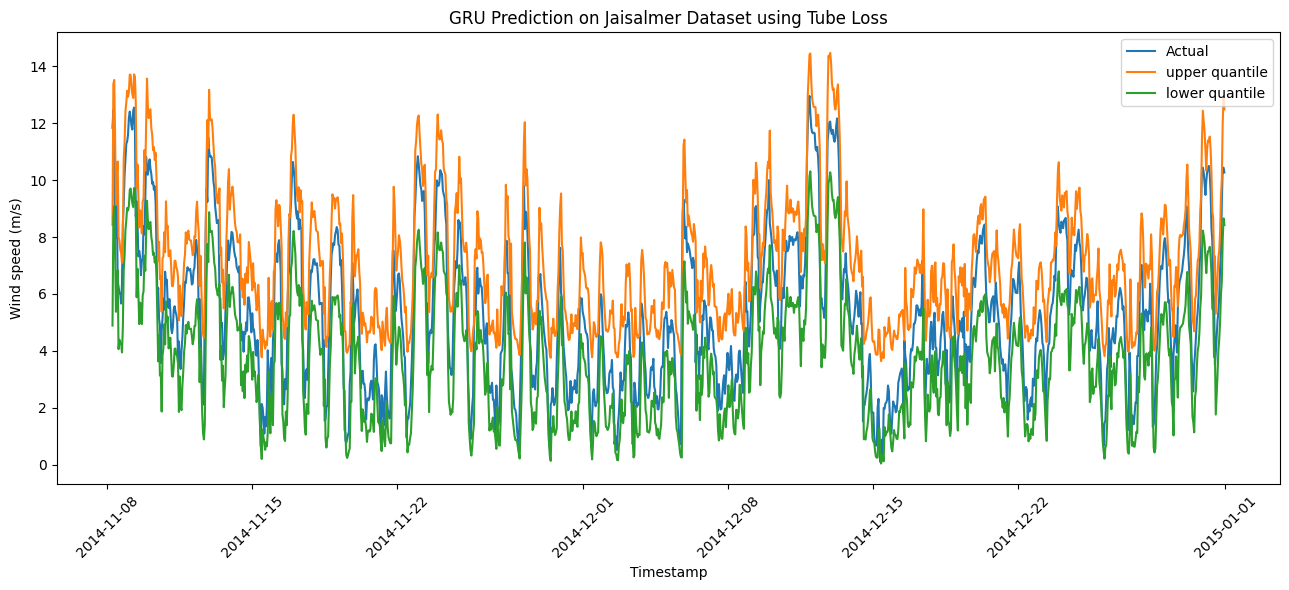

In [49]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU Prediction on Jaisalmer Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [50]:
Confidence_GRU.save('j_GRU_Confidence.keras')

###### Confidence TCN

In [51]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
for dropout in [0.1]:
    for kernel in [3]:
        for layers in [[128]]:
            for ri in [0.5]:
                for qi in [0.95]:
                    for deltai in [0.03]:
                        change_confidence_var(ri, qi, deltai)
                        tcn_Confidence = create_tcn(input_shape=(input_window_size,1),
                                               filters_list=layers,
                                               kernel_size=kernel,
                                               dropout_rate=dropout)
                        tcn_Confidence.compile(loss=confidence_loss, optimizer=Adam(learning_rate=0.001))
                        epc = 300
                        stop_patience = 10
                        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
                        start_time = datetime.datetime.now()
                        history = tcn_Confidence.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128, validation_data=(val_x, val_y), callbacks=[early_stopping])
                        end_time = datetime.datetime.now()
                        total_time = end_time - start_time
                        total_time = round(total_time.total_seconds(),2)
                        print('seconds taken:', total_time, '\nstart_time:', start_time.strftime('%H:%M:%S'), 'end_time:', end_time.strftime('%H:%M:%S'))
                        y_pred = tcn_Confidence.predict(test_x, verbose=0)
                        y_pred = scaler_y.inverse_transform(y_pred)
                        test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
                        test_y_ = np.squeeze(test_y_[:,0])
                        y_u_pred = y_pred[:,0]
                        y_l_pred = y_pred[:,1]
                        K_u = y_u_pred > test_y_
                        K_l = y_l_pred < test_y_
                        PICP = np.mean(K_u * K_l)
                        MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
                        print('PICP:', PICP)
                        print('MPIW:', MPIW)
                        save_to_csv(savefilename, dataset, "Confidence_TCN", PICP, MPIW, total_time, stop_patience, input_window_size, r, q, delta, layers, dropout, kernel)

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.1053 - val_loss: 0.0215
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0256 - val_loss: 0.0180
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0176
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0156
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0155
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0155
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.0145
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0150
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.0142
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0149
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0140
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

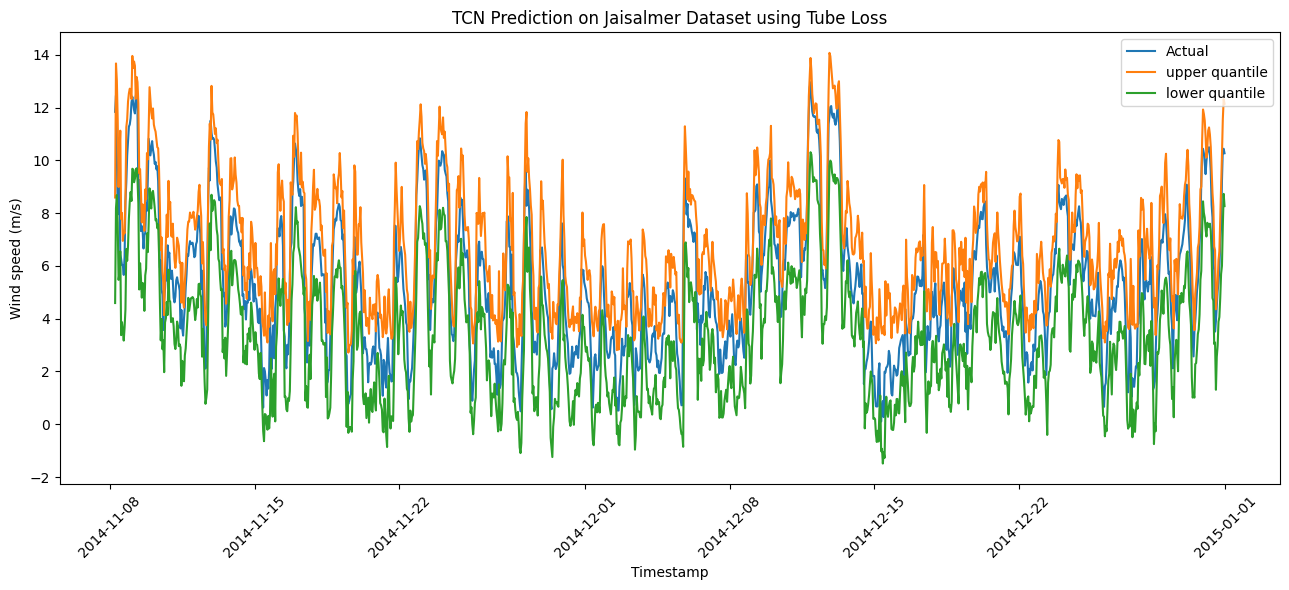

In [52]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN Prediction on Jaisalmer Dataset using Tube Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [53]:
tcn_Confidence.save('j_TCN_Confidence.keras')

##### Quantile Loss

###### Quantile LSTM

In [54]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64]
dropout = 0
quantile1 = create_lstm((input_window_size,1),layers,1,dropout)
quantile2 = create_lstm((input_window_size,1),layers,1,dropout)

In [55]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
q1=0.025
q2=0.975
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [56]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0093 - val_loss: 0.0063
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [57]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.2018 - val_loss: 0.0072
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0072
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0072
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0072
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0072
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [58]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9790697674418605
MPIW: 4.937


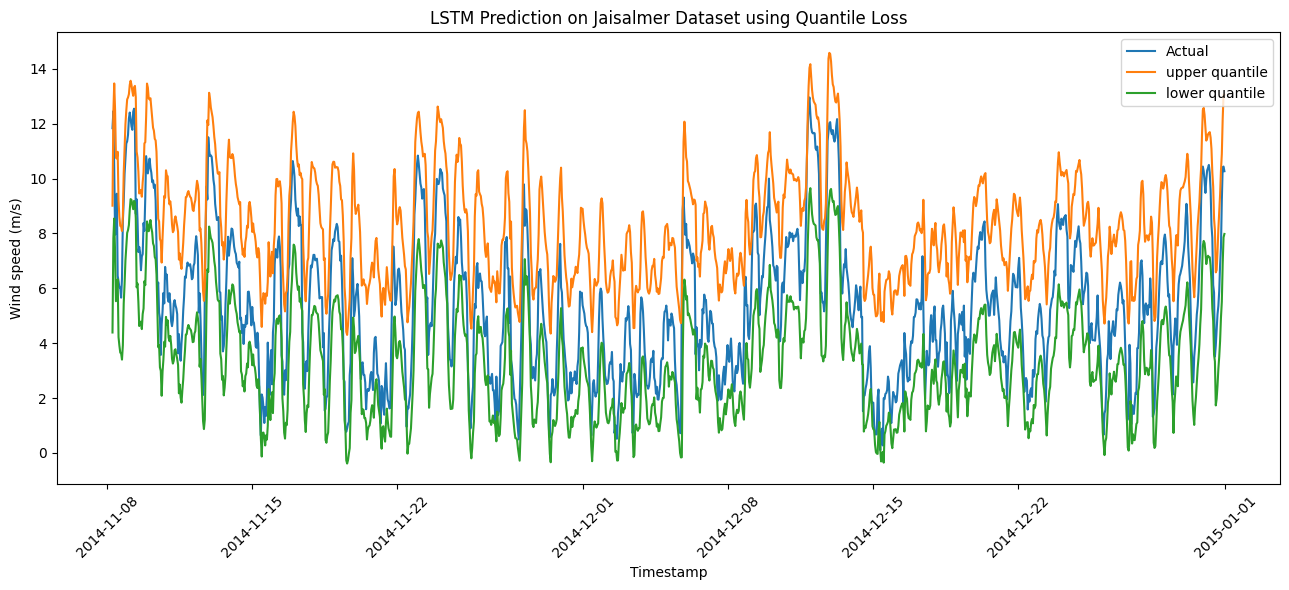

In [59]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('LSTM Prediction on Jaisalmer Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [60]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_LSTM", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout)

Data appended successfully to quantile_jaisalmer.csv


In [61]:
quantile1.save('j_lstm_q1.keras')
quantile2.save('j_lstm_q2.keras')

###### Quantile GRU

In [62]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64]
dropout = 0
quantile1 = create_gru((input_window_size,1),layers,1,dropout)
quantile2 = create_gru((input_window_size,1),layers,1,dropout)

In [63]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
q1=0.025
q2=0.975
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [64]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0048
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [65]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.2074 - val_loss: 0.0114
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0064
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [66]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9891472868217054
MPIW: 5.365


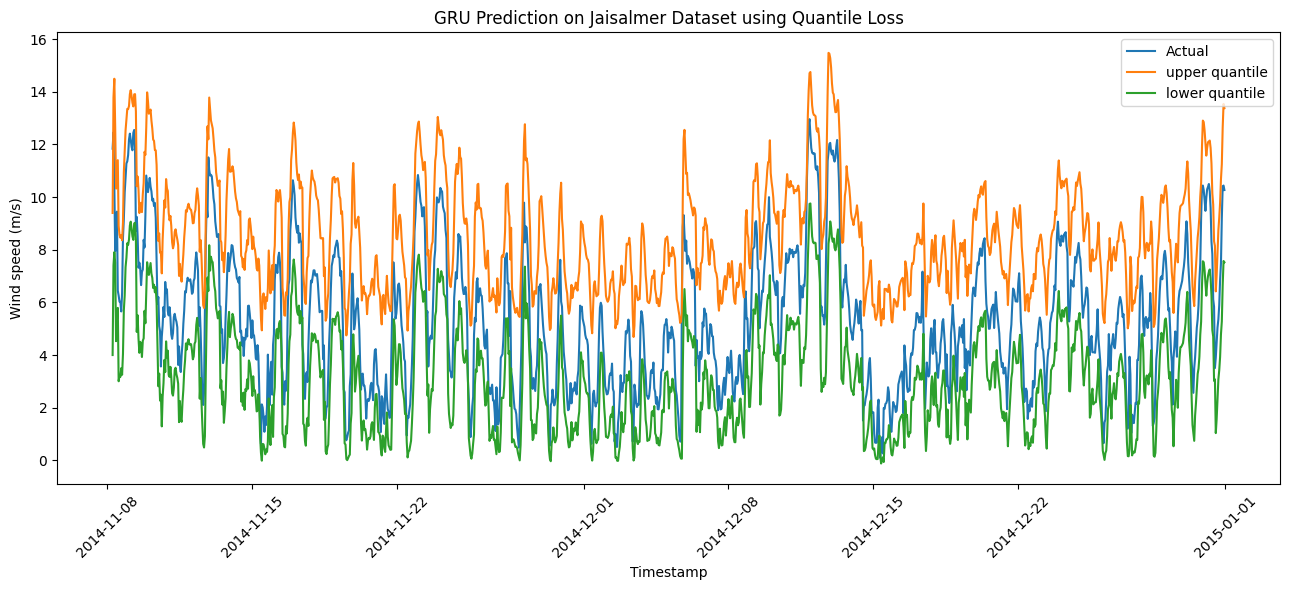

In [67]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('GRU Prediction on Jaisalmer Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [68]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_GRU", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout)

Data appended successfully to quantile_jaisalmer.csv


In [69]:
quantile1.save('j_gru_q1.keras')
quantile2.save('j_gru_q2.keras')

###### Quantile TCN

In [70]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
layers = [64,64]
dropout = 0
kernel = 5
quantile1 = create_tcn((input_window_size,1), layers, kernel, dropout)
quantile2 = create_tcn((input_window_size,1), layers, kernel, dropout)

In [71]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
q1=0.025
q2=0.975
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.001))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.001))

In [72]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time1 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time1,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [73]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=128,  validation_data=(val_x, val_y), callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time = end_time - start_time
total_time2 = round(total_time.total_seconds(),2)
print('seconds taken:', total_time2,
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0391 - val_loss: 0.0064
Epoch 2/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 3/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 4/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 5/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 6/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 7/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 8/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 9/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 10/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 11/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 12/300
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [74]:
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = scaler_y.inverse_transform(test_y.reshape(-1,1))
# test_y_ = np.squeeze(test_y_[:,0])
y_l_pred = scaler_y.inverse_transform(y_l_pred)
y_u_pred = scaler_y.inverse_transform(y_u_pred)
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred),3)
print('PICP:', PICP)
print('MPIW:', MPIW)

PICP: 0.9674418604651163
MPIW: 4.094


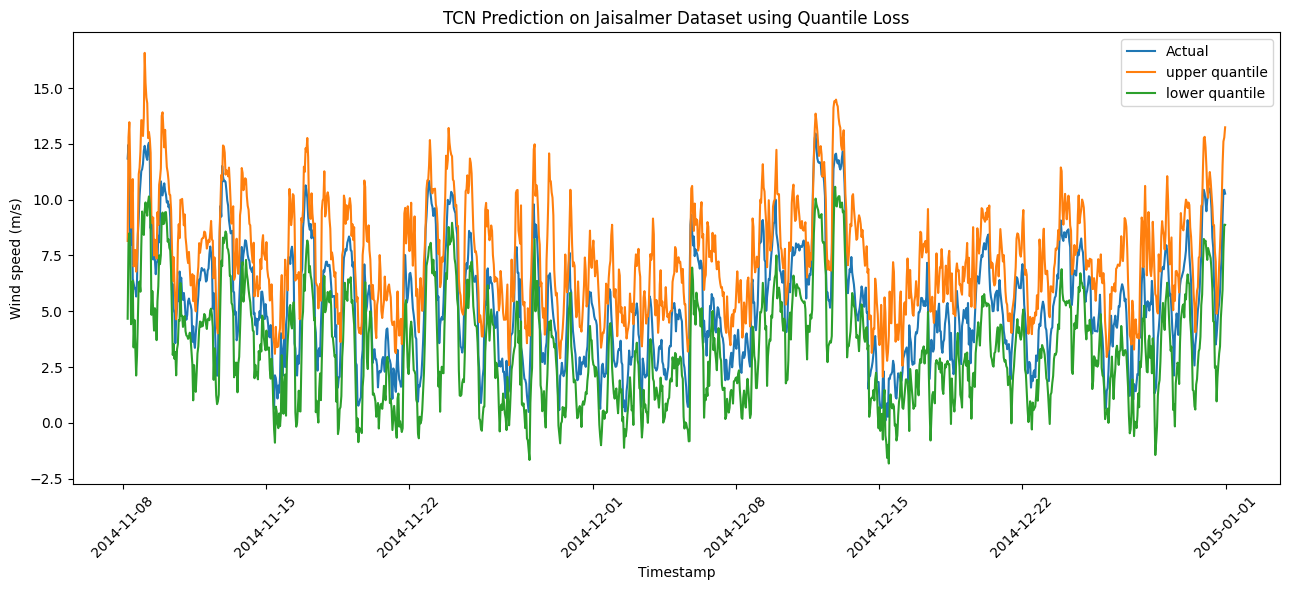

In [75]:
actual=test_y_
# actual = np.squeeze(actual)
pred1=y_u_pred[:,:1]
pred2=y_l_pred[:,:1]
numEx = test_data.index
numEx = numEx[24:]
plt.figure(figsize=(13, 6))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='upper quantile')
plt.plot(numEx,pred2,label='lower quantile')
plt.legend(loc='upper right')
plt.title('TCN Prediction on Jaisalmer Dataset using Quantile Loss')
plt.xlabel('Timestamp')
plt.ylabel('Wind speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('k_lstm_tube')
plt.show()

In [76]:
save_to_csv("quantile_"+savefilename, dataset, "Quantile_TCN", PICP, MPIW, total_time1 + total_time2, stop_patience, input_window_size, q1, q2, layers, dropout, kernel)

Data appended successfully to quantile_jaisalmer.csv


In [77]:
quantile1.save('j_tcn_q1.keras')
quantile2.save('j_tcn_q2.keras')